# Realizado hoy (21/5)
- Solucionado bug de reporting, que tomaba incorrectamente el valor previo.
- Optimizado el flujo cuando sólo se cambian los parámetros de búsqueda.
- Aprendido shortcut alt + flecha para desplazar líneas de código

# Ideas pendientes

- Incluir: en el gráfico superior (precios), le rentabilidad day to day, y en el inferior (OBV) el volumen como histograma.
- Convertir el precio close en valor intermedio High Low.
- Implementar get_labels en subtítulo de gráfico para tener más información
- Idea de un report general y uno especializado con "más cosas" (RSI, más largo plazo de análisis, etc). No se puede hacer fácilmente invocando la función, hay que o bien repetir o irse a clases.
- Convertir, para ello, filterset en clases.
- Algunas ideas de inversión (LYV, etc)

In [1]:


import pandas as pd
from functions import calc, retrieve, visualize as viz

import warnings
warnings.filterwarnings('ignore')

%colors nocolor

In [2]:
def get_and_store_raw_data(fromCSV, numberOfStocks=50, daysSince=30):
    tickers_df = retrieve.get_tickers(numberOfStocks)
    
    if (fromCSV):
        (rawdata, spreads, volumes, highs, lows) = retrieve.get_from_CSV()
    else:
        downloadedData = retrieve.get_downloaded_data(tickers_df, numberOfStocks, daysSince)
        (rawdata, spreads, volumes, highs, lows) = retrieve.distribute_data(downloadedData)
        retrieve.save_data(rawdata, spreads, volumes, highs, lows)

    return (rawdata, spreads, volumes, tickers_df, highs, lows)
    
def processData(closes, volumes, QUICK_EMA_PERIOD=12, SLOW_EMA_PERIOD=26, latestWindow=2):
    print ("Calculating indicators...")
    companies = closes.columns.values

    EMA_df = calc.get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD, closes)
    OBV_df= calc.get_OBV_df(volumes, closes)
    keyStats = calc.get_intersection_point(EMA_df, closes)
    (keyStats['avgRatio'], keyStats['MinAbsRatio']) = calc.ratioWrapper(EMA_df, companies, keyStats)
    keyStats['lastMAR']=EMA_df['Ratio'].iloc[-1]
    keyStats['latestGrowth'] = round(closes.pct_change()[-latestWindow:].min(),5)
    keyStats['ratioContr'] = calc.get_stocks_growing_now(closes, keyStats, 3)

    keyStats['LVTH_ratio']=get_trending(volumes)

    return(EMA_df, OBV_df, keyStats) 

import matplotlib.pyplot as plt

def plot_one_with_obv(x, EMA_df, closes, OBV_df):
    fig, axs = (plt.subplots(2, sharex=True))
    x_axis = closes.index
    axs[0].plot(x_axis, EMA_df['Quick'][x], 'r')
    axs[0].plot(x_axis, EMA_df['Slow'][x], 'b')
    axs[0].plot(x_axis, closes[x], 'g')
    axs[1].plot(x_axis, OBV_df[x], 'g')


def showData(closes, spreads, volumes, EMA_df, OBV_df, keyStats, filterSet, tickers_df):
    filteredCompanies = viz.filter_companies(keyStats, filterSet)
    #filteredCompanies.to_csv("./logs/filteredCompanies_" + pd.to_datetime('today').strftime('%Y%m%d')) 
    viz.plot_all(closes, spreads, volumes, EMA_df, OBV_df, filteredCompanies, tickers_df, keyStats, limit=3)



In [3]:
"""
Filterset Sample. Use 0 or comment for Neutral

filterSet = dict({
    "aboveAvgRatio":1, 
    "aboveMinAbs":1, 
    "minPositivePeriod":4, 
    "ratioContr":1, 
    "latestGrowth":0.8
    })

timeframes dict({
    daysSince,
    qema_period,
    sema_period
    }) 
"""

""" filterSet = dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":0.005
     }) """


def get_trending(volumes):
    difference = (volumes.iloc[-1]-volumes.mean())
    ratio = difference /(volumes.mean().abs())
    return (ratio)

#finalList = ratio.sort_values(ascending=False)

def get_reset_mode(numberOfStocks, daysSince, filterSet):
    global  search_params_cache, filter_params_cache, keyStats
    
    search_params_current = dict(numberOfStocks=numberOfStocks, daysSince = daysSince)
    resetMode = 0
    #if (('filter_params_cache' not in globals()) or ('keyStats' not in globals()) or (filterSet != filter_params_cache)): resetMode = 1
    if ('keyStats' not in globals()): resetMode = 1
    if (('search_params_cache' not in globals()) or ('closes' not in globals()) or (search_params_current != search_params_cache)): resetMode = 2

    search_params_cache = search_params_current
    filter_params_cache = filterSet
    #print (f"Reset mode is {resetMode}")
    return (resetMode)

def find_stocks(filterSet, numberOfStocks=500, daysSince=30):
    global closes, spreads, volumes, EMA_df, OBV_df, keyStats, tickers_df

    resetMode = get_reset_mode(numberOfStocks=numberOfStocks, daysSince=daysSince, filterSet=filterSet)
    fromCSV = False

    if (resetMode == 2):
        print ("Raw data did not exist or search params were changed. Downloading...")
        fromCSV = retrieve.from_CSV(daysSince, numberOfStocks)
        #fromCSV = False #Overriding
        (closes, spreads, volumes, tickers_df, highs, lows)= get_and_store_raw_data(fromCSV=fromCSV, numberOfStocks=numberOfStocks, daysSince=daysSince)

    if (resetMode >= 1):
        print ("Filters and processed data did not exist or search params were changed. Processing...")
        (EMA_df, OBV_df, keyStats) = processData(closes, volumes, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2)


    showData(closes, spreads, volumes, EMA_df, OBV_df, keyStats, filterSet, tickers_df)
    
    return (closes, spreads, volumes, EMA_df, keyStats, tickers_df, highs, lows)

#(closes, spreads, EMA_df, keyStats) = find_stocks(filterSet)



Raw data did not exist or search params were changed. Downloading...
Is it possible to use cached data? False
Initiating download...
--> Requested days: 90.
--> Requested stocks: 100.
[*********************100%***********************]  100 of 100 completed
Filters and processed data did not exist or search params were changed. Processing...
Calculating indicators...
--> EMA Dataframe calculated.
--> Intersection points found.
--> Absolute and Relative Mins calculated.
Starting filtering...
--> Main companies filtered. 100 outstanding companies.
Displaying 10 first companies


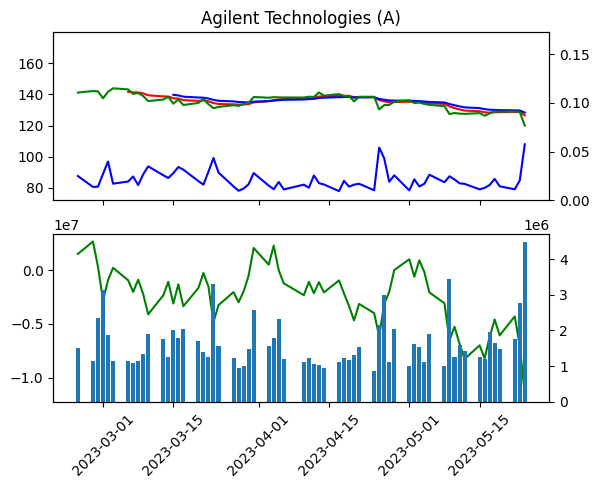

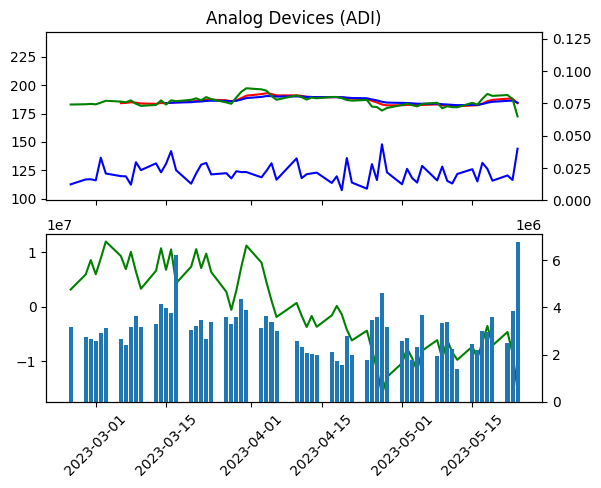

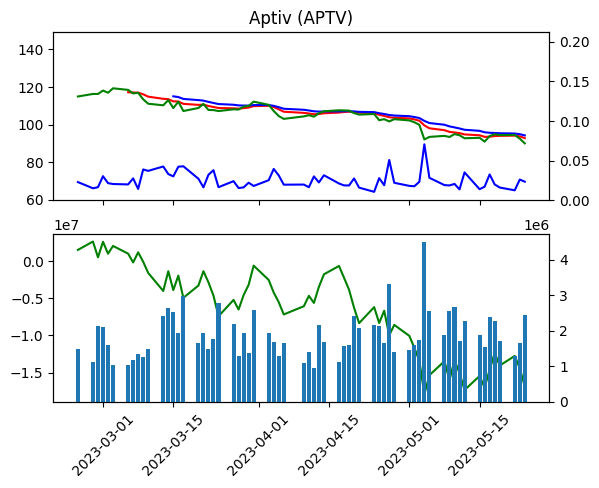

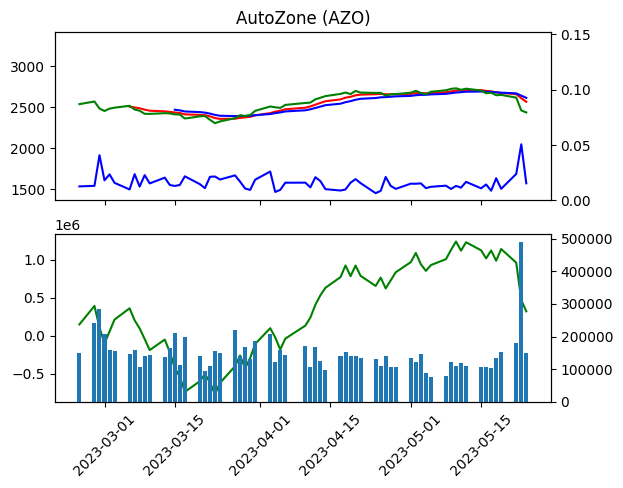

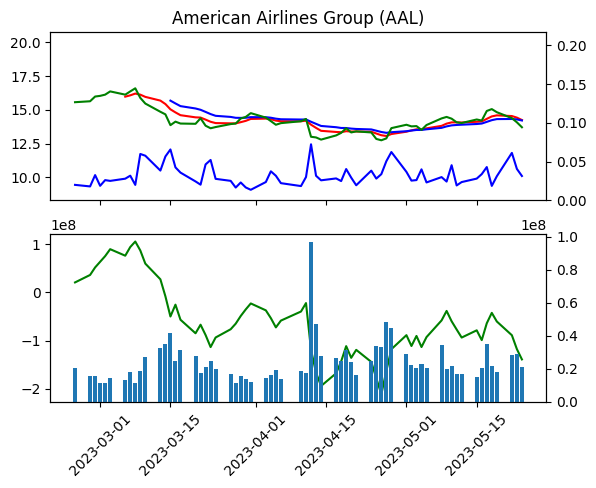

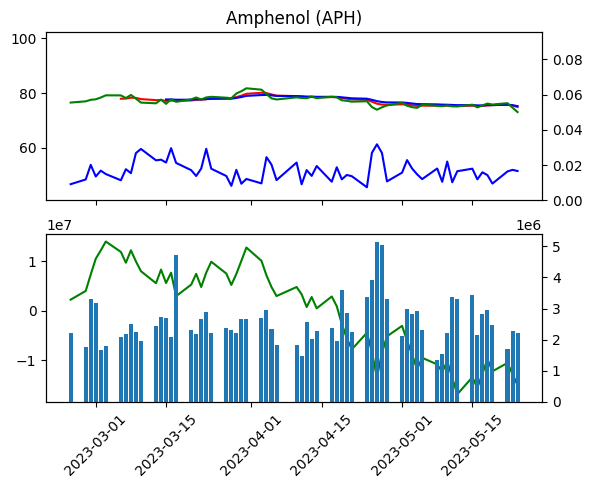

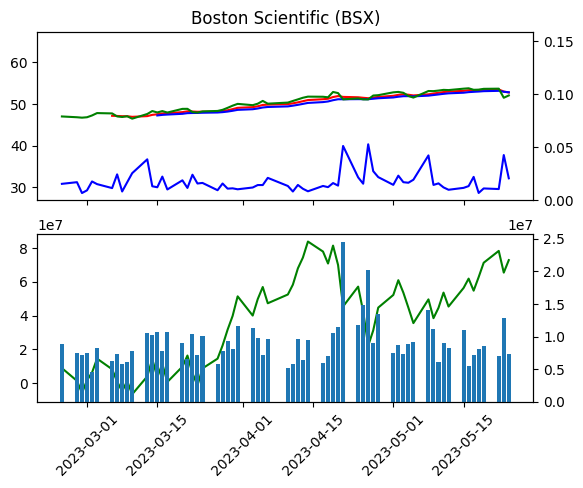

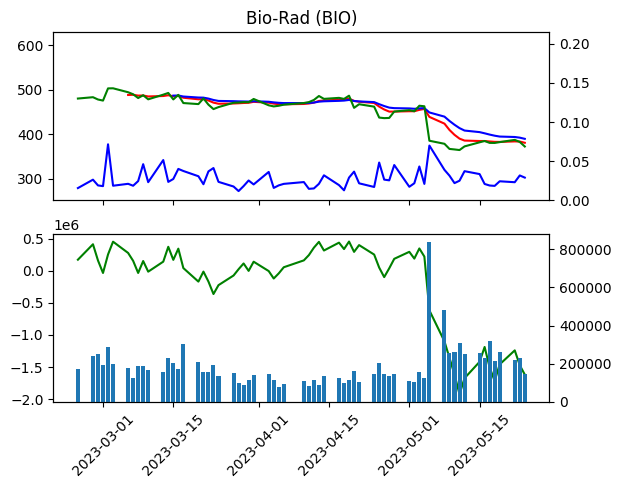

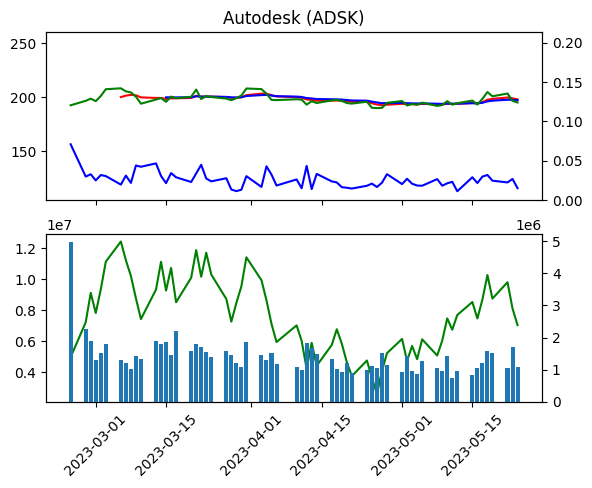

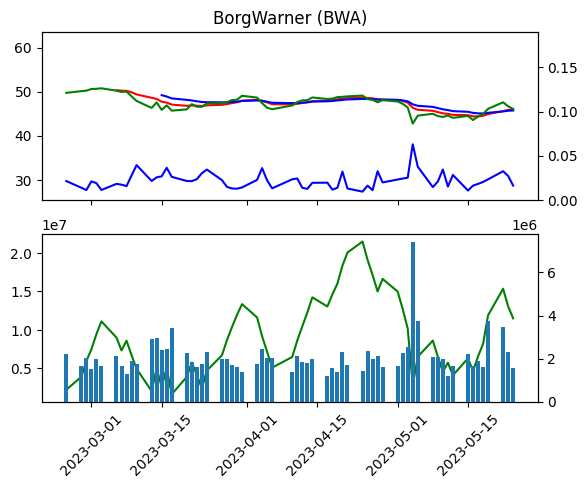

In [4]:

(closes, spreads, volumes, EMA_df, keyStats, tickers_df, highs, lows) = find_stocks(numberOfStocks=100, daysSince=90, filterSet=dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":-1, #Originally 0.0001 
    #"minPositivePeriod":4, 
    "ratioContr":-1,
    "latestGrowth":-1 #Originally 0.005
     }))
    

(-1.0, 5.5)

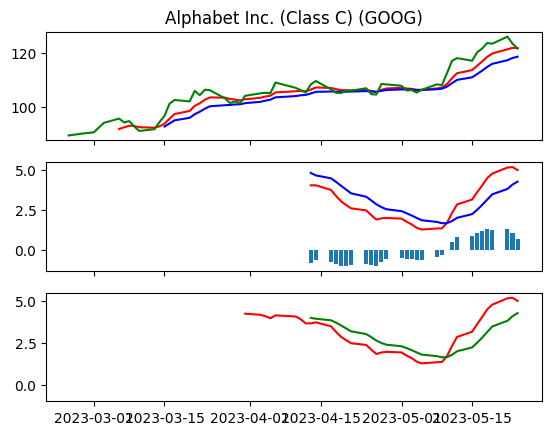

In [27]:
##PRobando con el MACD..

import talib 
import matplotlib.pyplot as plt


x = 'GOOG'
x_axis = closes.index

macd = talib.MACD(closes[x], 12, 26)

fEMA = talib.EMA(closes[x], 12)
sEMA = talib.EMA(closes[x], 26)
macd_test = fEMA-sEMA
macd_signal = talib.EMA(macd_test, 9)



fig, axs = (plt.subplots(3, sharex=True))
#Plotting price and EMA charts
axs[0].set_title(tickers_df.loc[x]['Name'] + " (" + x +")")
axs[0].plot(x_axis, EMA_df['Quick'][x], 'r')
axs[0].plot(x_axis, EMA_df['Slow'][x], 'b')
axs[0].plot(x_axis, closes[x], 'g')
#axs[0].set_ylim([110,130])

axs[1].plot(x_axis, macd[0], 'r')
axs[1].plot(x_axis, macd[1], 'b')
axs[1].bar(x_axis, macd[2])

axs[2].plot(x_axis, macd_test, 'r')
axs[2].plot(x_axis, macd_signal, 'g')
axs[2].set_ylim([-1,5.5])

#axs[0].set_ylim([0.5*maxlim, 1.25*maxlim])



<BarContainer object of 63 artists>

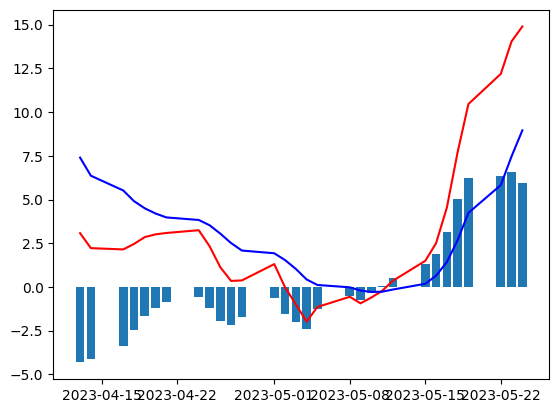

In [85]:
def get_macd_dataframe(closes):
    macd_dict=dict()
    macd_last_dict = dict()
    for x in closes.columns:
        macd_dict[x] = talib.MACD(closes[x], 12, 26)
        macd_last_dict[x] = macd_dict[x][2].iloc[-1]
    macd_df = pd.DataFrame(macd_dict)
    macd_last_df = pd.DataFrame(macd_last_dict, index=[0])
    return(macd_df, macd_last_df)


x = 'AVGO'
(macd_df, macd_last_df) = get_macd_dataframe(closes)
keyStats['lastMACD'] = macd_last_df.transpose()[0]
fig, axs = (plt.subplots(1, sharex=True))

axs.plot(x_axis, macd_df[x][0], 'r')
axs.plot(x_axis, macd_df[x][1], 'b')
axs.bar(x_axis, macd_df[x][2])


In [77]:
macd_last_df.transpose().sort_values(by=0, ascending=False)

,0
AVGO,5.941066
ALB,3.447694
ADBE,2.771436
BLK,2.377261
ACN,1.603076
...,...
AJG,-1.771691
BIIB,-2.224819
AON,-2.444712
BKNG,-3.791421


In [84]:
macd_last_df.transpose()[0]

A      -0.397867
AAL    -0.004887
AAP    -0.745426
AAPL   -0.479518
ABBV   -0.251170
          ...   
MMM    -0.134459
MO     -0.153140
T      -0.034379
TECH   -0.130114
WRB     0.031698
Name: 0, Length: 100, dtype: float64

In [53]:
macd_dict_test['test'][2].iloc[-1]

0.7270730114046069

In [15]:
test[0].tail(10)

Date
2023-05-11    2.321865
2023-05-12    2.858184
2023-05-15    3.169224
2023-05-16    3.626487
2023-05-17    4.054297
2023-05-18    4.506007
2023-05-19    4.787023
2023-05-22    5.161642
2023-05-23    5.190513
2023-05-24    5.007998
dtype: float64

In [14]:
talib.EMA(real2double(rawdata[x].values), timeperiod=qema_period)

AttributeError: 'tuple' object has no attribute 'signal'

In [9]:
filteredCompanies = viz.filter_companies(keyStats, filterSet=dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, #Originally 0.0001 
    #"minPositivePeriod":4, 
    "ratioContr":0,
    "latestGrowth":-1 #Originally 0.005
     }))

#import matplotlib.pyplot as plt

#fig, axs = (plt.subplots(2))
#x_axis = closes.index
#axs[0].bar([x_axis], volumes['LYV'], 'b')
#axs[0].bar(x_axis, volumes['LYV'])


Starting filtering...
--> Main companies filtered. 39 outstanding companies.


In [10]:
EMA_df['Ratio']['LYV']

KeyError: 'LYV'

In [ ]:
x_axis.values

NameError: name 'x_axis' is not defined

In [ ]:
volumes['LYV'].values

In [ ]:
type(closes.index.values
    )

In [ ]:
import talib

test = talib.RSI(closes['ABBV'])

In [ ]:
plot_one_with_obv('GOOGL', EMA_df, closes, OBV_df)

In [ ]:
OBV_df[testcompany][-5:]


In [ ]:
testcompany = 'EXPE'
print(f"Últimos 5 días: {OBV_df[testcompany][-5:].mean()}, Rango total: {OBV_df[testcompany].mean()}")

In [ ]:
plot_one_with_obv(testcompany, EMA_df, closes, OBV_df)

In [ ]:
OBV_df.mean()

In [ ]:
OBV_df= calc.get_OBV_df(volumes, closes)

In [ ]:
OBV_df.iloc[-1]

In [ ]:
#This should probably be a class for reuse.
#Failed attempt to get a more detailed view of a stock, because when it's only 1 stock to be downloaded, we get a series and not a dataframe, causing lots of errors.

import pandas as pd
import yfinance as yf

def wider_look(company, range):
    (ts_today, ts_origin) = retrieve.get_timestamps(range)
    (closes, spreads, volumes) = retrieve.distribute_data(yf.download(company, start=ts_origin, end=ts_today).fillna(0))
    EMA_df = calc.get_EMA_df(14, 26, closes)
    OBV_df= calc.get_OBV_df(volumes, closes)
    keyStats = calc.get_intersection_point(EMA_df, closes)
    plot_one_with_obv(company, EMA_df, closes, OBV_df)
    return (keyStats)

keyStats_test = wider_look('LYV LYV', 60)

In [ ]:
EMA_df['Ratio']['LYV']

In [ ]:
closes.index[int(round((len(closes.index)/2),0))]

In [ ]:
closes.pct_change()['A']